In [1]:
import numpy as np
from itertools import cycle
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime as dt
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/development/withtides/regional-mom6/")

import regional_mom6 as rm
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43965,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:39321,Total threads: 4
Dashboard: /proxy/38119/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40329,


# TTide domain

In [2]:

## Choose your coordinates and the name of your experiment


yextent = [-56,-26]
xextent = [142,180]
expt_name = "full-40"

# 
daterange = ["2015-01-01 00:00:00", "2015-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/tasman-tides/rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/reanalysis_tmp/ttide-20"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)

In [3]:
reload(rm)
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.025,  ## Resolution
    100,      ## #zlayers
    20,       ## dz ratio
    5500,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)



In [11]:
a = expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time","y":"latitude","x":"longitude",
     "zl":"depth","eta":"zos","u":"uo","v":"vo",
     "tracers":{"salt":"so","temp":"thetao"}},
    boundaries = ["south","north","west","east"]
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
Processing south...Done.
Processing north...Done.
Processing west...Done.
Processing east...Done.


In [5]:
expt.bathymetry(
    '/g/data/v45/ab8992/synbath2/SYNBATH_V1.2.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"z"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1,
    #  maketopog=False
    )

Starting to regrid bathymetry. If this process hangs you might be better off calling ESMF directly from a terminal with appropriate computational resources using 

 mpirun ESMF_Regrid -s bathy_original.nc -d topog_raw.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional

This is better for larger domains.


Reading in regridded bathymetry to fix up metadata...done.


In [11]:
expt.FRE_tools((38,30))


NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=1140

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 1140
max_pe = 1140
layout = 38, 30
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>N

In [12]:
expt.setup_run_directory("",using_payu=True)

Number of CPUs required:  1025


In [ ]:
subprocess.run(f"cp default_rundir/era5_surface/* {rundir} -r",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[0]},{expt.layout[1]}\n'

    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[0]},{expt.layout[1]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"

inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


# Modify input.nml 
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "current_date" in lines[i]:
        tmp = daterange[0].split(" ")[0].split("-")
        lines[i] = f"{lines[i].split(' = ')[0]} = {int(tmp[0])},{int(tmp[1])},{int(tmp[2])},0,0,0,\n"

 
inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/ttide/testtides-40//inputdir/testtides-40': File exists


## Add Tides to an Existing Run
Offline I've copied all the inputs from the ttide-20 run. All that this notebook does is use the out-of-the-box NWA scripts to add tidal constituents. I'll then need to go back to the MOM_input file from my old tide test to rectify the new one 

In [ ]:
os.chdir("/home/149/ab8992/cosima_regional/withtides/mom6-regional/")
os.listdir()
import boundary_tides as bt

In [15]:
## VERBATIM COPY OLD CODE AND SEE WHAT HAPPENS

# """
# constituents in TPXO9:
# con =
# "m2  ",  0
# "s2  ",  1
# "n2  ",  2
# "k2  ",  3
# "k1  ",  4
# "o1  ",  5
# "p1  ",  6
# "q1  ",  7
# "mm  ",  8
# "mf  ",  9
# "m4  ", 10
# "mn4 ", 11
# "ms4 ", 12
# "2n2 ", 13
# "s1  "  14
# """
# Use these constituents:
# (MOM6 does not currently support m4, mn4, ms4, 2n2, or s1.)
# constituents = range(0, 10)

constituents = [0]

# Hardcoded for my ttide domain!!! 

horizontal_subset = dict(ny=slice(200,380), nx=slice(850,1100))

# Path to tpxo9.v1 data
tpxo_dir = '/g/data/nm03/TPXO'

# Save output here
output_dir = inputdir + "/forcing"

# Setup NWA boundaries
hgrid = xr.open_dataset(inputdir + '/hgrid.nc')
# segments taken from nwa25_obc.py
segments = [
    bt.Segment(1, 'south', hgrid, output_dir=output_dir),
    bt.Segment(2, 'north', hgrid, output_dir=output_dir),
    bt.Segment(3, 'west', hgrid, output_dir=output_dir),
    bt.Segment(4, 'east', hgrid, output_dir=output_dir)
]
reload(bt)
bt.write_tpxo(constituents, tpxo_dir, segments, horizontal_subset,"tpxo9.v1.nc")

In [ ]:
reload(bt)

<module 'boundary_tides' from '/home/149/ab8992/cosima_regional/withtides/mom6-regional/boundary_tides.py'>

[142, 180] [-56, -26]
125.083336


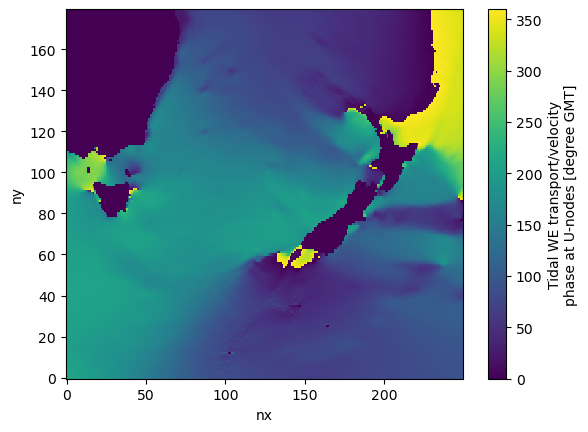

In [ ]:
tides = xr.open_dataset("/g/data/nm03/TPXO/u_tpxo9.v1.nc")


tides.up.isel(nc = 0,nx = slice(850,1100),ny = slice(200,380)).plot(x = "nx")
# tides.up.isel(nc = 0).plot(x = "nx")
print(xextent,yextent)
print(tides.lon_u.isel(nx = 750,ny = 0).values)

In [ ]:
print(tides.lon_u.isel(nx = 1100,ny = 0).values)
print(tides.lat_u.isel(nx = 1100,ny = 380).values)

183.41667
-26.666668


## Modify the default input directory to make a (hopefully) runnable configuration out of the box

In [ ]:
subprocess.run(f"cp default_rundir/era5_surface/* {rundir}",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)
# subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")



## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify data table
text = """
"ATM", "p_surf", "sp", "./INPUT/forcing/sp_ERA5", "bilinear", 1.0
"ATM", "p_bot",  "sp", "./INPUT/forcing/sp_ERA5", "bilinear", 1.0
"ATM", "t_bot",  "t2m", "./INPUT/forcing/2t_ERA5", "bilinear", 1.0
"ATM", "sphum_bot", "q", "./INPUT/forcing/q_ERA5", "bilinear", 1.0
"ATM", "u_bot", "u10", "./INPUT/forcing/10u_ERA5", "bicubic", 1.0
"ATM", "v_bot", "v10", "./INPUT/forcing/10v_ERA5", "bicubic", 1.0
"ATM", "z_bot", "", "", "bilinear", 10.0
"ATM", "gust", "", "", "bilinear", 1.0e-4
"ICE", "lw_flux_dn", "rlds", "./INPUT/RYF.rlds.1990_1991.nc", "bilinear", 1.0
"ICE", "sw_flux_vis_dir_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.285
"ICE", "sw_flux_vis_dif_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.285
"ICE", "sw_flux_nir_dir_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.215
"ICE", "sw_flux_nir_dif_dn", "rsds", "./INPUT/RYF.rsds.1990_1991.nc", "bilinear", 0.215
"ICE", "lprec", "prrn", "./INPUT/RYF.rain.1990_1991.nc", "bilinear", 1.0
"ICE", "fprec", "prsn", "./INPUT/RYF.snow.1990_1991.nc", "bilinear", 1.0
"ICE", "runoff", "friver", "./INPUT/runoff_regrid.nc", "none", 1.0
"ICE", "dhdt", "", "", "none", 80.0
"ICE", "dedt", "", "", "none", 2.0e-6
"ICE", "drdt", "", "", "none", 10.0
"LND", "rough_mom", "", "", "none", 0.01
"LND", "rough_heat", "", "", "none", 0.1"""
inputfile = open(f"{rundir}/data_table",'w')
inputfile.writelines(text)
inputfile.close()

## Modify namelist to set start date
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()

for i in enumerate(lines):
    if "current_date" in i[1]:
        d = dt.datetime.strptime(daterange[0],"%Y-%m-%d %H:%M:%S")
        lines[i[0]] = lines[i[0]].split("=")[0] + f"= {d.year},{d.month},{d.day},{d.hour},{d.minute},{d.second},\n" 

inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/ttide/testtides-20//inputdir/testtides-20': File exists
